### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [28]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.svm import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

In [35]:
prev_mth = rets.index[0]
start_mth = prev_mth + pd.DateOffset(months=1)

In [36]:
#rank transform wrds
dfs = []
for name, df_group in wrds_svm.groupby(['MonthStart']):
    ranked_df = df_group.loc[:,'srcq':'Vol'].rank(axis = 0)/(len(df_group)+1)
    standardized_df = (ranked_df - ranked_df.mean(axis = 0))/ranked_df.std(axis = 0)
    standardized_df.drop(columns= ['DIFFYear', 'date', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays', 'DIFFExpectedDaysCorr'], inplace = True)
    dfs.append(standardized_df)
wrds_standard = pd.concat(dfs, axis = 0, ignore_index= False)

In [37]:
#groupby then rank within groups
flattened_returns = rets.melt(ignore_index=False, var_name='tic').reset_index()
flattened_returns = flattened_returns.rename(columns ={'StartMonth': 'MonthStart'})
flattened_returns.index = pd.MultiIndex.from_frame(flattened_returns[['MonthStart', 'tic']])
flattened_returns.drop(columns = ['MonthStart', 'tic'], inplace=True)
dataset = pd.merge(flattened_returns, wrds_standard, left_index=True, right_index=True, how = 'inner')
dataset.sort_index(inplace=True)

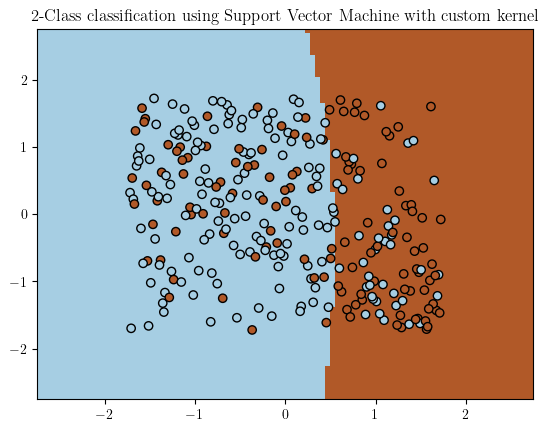

The best parameters are {'sbf__gamma': 0.0016, 'svm__C': 125.0, 'svm__kernel': 'precomputed'} with a score of 0.66


In [258]:
from sklearn.model_selection import StratifiedShuffleSplit

idx = pd.IndexSlice
tics = list(rets.columns)
X = dataset.loc[idx[start_mth,:], ['Vol', 'ceqq']].values #['Vol', 'ceqq']].values #'srcq':'Vol'].values
y = dataset.loc[idx[start_mth,:], 'value'].values
y = (y  >= np.percentile(y, 57)).astype(int)
cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
C_range = np.logspace(-1, 5, 10, base = 5)
gamma_range = np.logspace(-4, 1, 10, base=5)

grid = train_svm(X, y, gamma_range, C_range, cv, plot=True)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


In [254]:
class DualSVM:
    # This class models the support vector machine sub problem in the ADM method
    big_m = 100
    # noinspection PyTypeChecker
    def __init__(self, tics, exogenous, soft_margin, previous_exogenous = None, mvo_z=None, kernel = None, epsilon=0.001):
        self.tics = tics  # list of tickers
        self.exogenous = exogenous  # n by p matrix of features for the tickers
        self.prev_exogenous = previous_exogenous
        self.soft_margin = soft_margin  # hyper parameter
        n, m = self.exogenous.shape

        self.model = gp.Model(env=e)
        self.kernel = kernel
        self.alpha = self.model.addMVar(n, lb=0, ub = self.soft_margin)
        self.mvo_z = mvo_z
        self.epsilon = epsilon

    @property
    def svm_objective(self):
        kernel.fit(self.exogenous)
        self.Q = kernel.transform(self.exogenous)
        self.u = 2*self.mvo_z - 1
        if len(self.mvo_z.shape) == 1:
            self.u = np.expand_dims(self.u, axis=1)
        U = self.u@self.u.T
        QU = np.multiply(self.Q, U)
        return self.alpha.sum() - (1 / 2) * (self.alpha @ QU @ self.alpha)

    # def svm_change(self, alpha_star):
    #     n, m = self.exogenous.shape
    #
    #     return (1 / 2) * (w_diff @ w_diff)

    def set_model(self, svm_constrs=None, delta=0, alpha_star=None, previous_exogenous = None):

        self.previous_exogenous = previous_exogenous
        # remove constraints

        self.model.remove(self.model.getConstrs())
        # parameter definitions

        # objective function components
        if svm_constrs:
            for con in svm_constrs:
                self.model.addConstr(con, 'target')

        if alpha_star is not None:
            hyperplane_penalty = (1-delta)*self.svm_objective #+ delta*self.svm_change(alpha_star)
        else:
            hyperplane_penalty = self.svm_objective

        self.model.setObjective(hyperplane_penalty, GRB.MAXIMIZE)

        self.model.addConstr(self.u.T@self.alpha == 0)
        #update bounds here

    def optimize(self, cbb=None):
        n, m = self.exogenous.shape
        if cbb not in [None]:
            self.model._cur_obj = float('inf')
            self.model._time = time.time()
            self.model.optimize(callback=cbb)
        else:
            self.model.optimize()

        v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)

        for i in range(n):
            if self.alpha[i].x < self.soft_margin:
                v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
                dot_product = self.Q[i,:]@v
                self.b = self.u[i][0] - dot_product

        self.decision_boundary = self.Q@v + self.b

    def predict(self, X):
        kernel.fit(self.exogenous)
        Q = kernel.transform(X)
        v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
        return np.sign(Q@v + self.b)

kernel = CustomRBFKernel(gamma = 0.023392141)

In [255]:
SVM_ = DualSVM(tics, X ,42.7495, kernel =kernel)
SVM_.mvo_z = y
SVM_.set_model()
SVM_.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1 rows, 286 columns and 286 nonzeros
Model fingerprint: 0xd08d1b97
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [4e+01, 4e+01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 1 rows, 286 columns, 286 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 31
 AA' NZ     : 4.960e+02
 Factor NZ  : 5.280e+02
 Factor Ops : 1.144e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.72141802e+06  2.33061724e+06  1.65e+04 1.84e-03  1.00e+06     0s
   1   6.25988545e+03  2.30844407e+06  4

In [256]:
plotSVC('Testing', X, y, SVM_)

In [227]:
grid.best_estimator_['svm'].dual_coef_

array([[-42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -11.03507967, -42.74939867,
        -42.74939867, -10.23067044, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
         -0.94572567, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -13.03730853, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.74939867, -42.74939867,
        -42.74939867, -42.74939867, -42.

In [151]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))
#preprocessing
cov_, mean_ = forecasts[start_mth]
N = len(mean_)

cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])

#get the wharton research data for the valid tickers for the month
#cols =  ['INV3', 'PRO6', 'INV1']
Y = wrds_standard.loc[(start_mth,), ['Vol', 'ceqq']] # Y matrix in formulation

dpi_setting = 150

In [152]:

ret_constr = -1 #no return constraint
soft_margin = 10 #preference for separation feasibility

name = "final"
ratio = 0.7 #% of assets
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-2, 1e-3, 1e-4]
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}


In [182]:
class MVO:
    # This class models the mean variance sub-problem in the ADM method

    big_m = 100

    # noinspection PyTypeChecker
    def __init__(self, tics, mean_ret, cov, ret_constr, asset_lim,
                 soft_margin=0, decision_boundary = None, asset_lim_lower=0, epsilon=0.001):
        self.tics = tics  # list of tickers
        self.mean_ret = mean_ret
        self.cov = cov
        self.ret_constr = ret_constr
        self.AssetLim = asset_lim
        self.AssetLim_Lower = asset_lim_lower
        n = len(mean_ret)

        self.model = gp.Model(env=e)
        self.x = self.model.addMVar(n)
        self.z = self.model.addMVar(n, vtype=GRB.BINARY)
        self.v = self.model.addMVar(n, lb=np.zeros(n))
        self.q = self.model.addMVar(n)
        self.xi = self.model.addMVar(n, lb=np.zeros(n))
        self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')

        self.decision_boundary = decision_boundary #vector for each asset defining decision boundary

        self.soft_margin = soft_margin

        self.epsilon = epsilon
        self.model.update()

        self.abs = self.model.addMVar(n)

        min_eig = min(np.linalg.eigvals(self.cov)) - 10 ** (-8)
        self.posdef_diag = np.diag(np.ones(n)) * min_eig

    @property
    def portfolio_risk(self):
        return self.x @ self.cov @ self.x

    @property
    def port_exptd_ret(self):
        return self.mean_ret[:, 0] @ self.x

    @property
    def soft_penalty(self):
        n = len(self.mean_ret)
        if np.isscalar(self.soft_margin):
            return (1 / n) * self.soft_margin * (self.xi.sum())
        else:
            return (1 / n) * (self.soft_margin[:, 0] @ self.xi)

    @property
    def portfolio_risk_p(self):
        return portfolio_risk_posdef(self)

    def print_var_info(self, names=None):

        # dictionary of variables and their names
        if names is None:
            names = {}
        for key in names.keys():
            print(key, names[key])
        print("x", self.x.X)
        print("z", self.z.X)
        print("")

    def set_model(self, set_return=True, constrs=None, warm_starts=None):

        # parameter definitions
        if constrs is None:
            constrs = []
        if warm_starts is None:
            warm_starts = []

        if warm_starts:  # start is a list
            self.x.start = warm_starts[0]
            self.z.start = warm_starts[1]
        self.model.remove(self.model.getConstrs())
        n = len(self.mean_ret)

        # objective function components
        if set_return:
            # remove constraints and reset the return constraints
            self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
        if constrs:
            for con in constrs:
                self.model.addConstr(con, 'target')

        self.model.update()
        self.model.addConstr(self.x.sum() == 1, 'budget')

        self.model.addConstr(self.z.sum() <= self.AssetLim, 'Cardinality')
        self.model.addConstr(self.z.sum() >= self.AssetLim_Lower, 'Cardinality')

        self.model.addConstr(self.x <= self.z, "z force x")
        self.model.setObjective(self.portfolio_risk + self.soft_penalty, GRB.MINIMIZE)

        # the SVM info must be uninitialized on the first run
        if self.decision_boundary is not None:
            for i in range(n):
                a = self.decision_boundary[i]
                # self.model.addConstr((-1) * self.epsilon + self.xi[i] + big_m * self.z[i] >= a, "svm1")
                # self.model.addConstr(-1 * big_m * (1 - self.z[i]) + 1 * self.epsilon - self.xi[i] - a <= 0, "svm2")
                self.model.addConstr(2*a[0]*self.z[i] >= a[0] + self.epsilon - self.xi[i], 'svm'+str(i))

    def optimize(self, cbb=None):

        if cbb not in [None]:
            self.model._cur_obj = float('inf')
            self.model._time = time.time()
            self.model.optimize(callback=cbb)
        else:
            self.model.optimize()
        self.model.write('portfolio_selection_optimization.lp')

    def evaluate(self, realized_ret):

        ret = np.dot(self.x.X, realized_ret)
        return ret  # use this to calculate out of sample rets and var

    def get_estimates(self):

        vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
        expt_ret_metric = self.port_exptd_ret.getValue()[0]
        return [vol_metric, expt_ret_metric]  # use this for efficient frontiers

    def define_turnover(self, x0, prices, limit, cost):
        for v, absv, curr in zip(self.x.tolist(), self.abs.tolist(), x0.tolist()):
            self.model.addConstr(absv >= v - curr, "turnover constraint1")
            self.model.addConstr(absv >= curr - v, "turnover constraint2")
        q = cost * 1 / np.maximum(1, prices)
        self.model.addConstr(self.abs @ q <= limit, "turnover constraint3")

class SVM:
    # This class models the support vector machine sub problem in the ADM method
    big_m = 100
    # noinspection PyTypeChecker
    def __init__(self, tics, exogenous, soft_margin, mvo_z=None, non_neg=True, epsilon=0.001):
        self.tics = tics  # list of tickers
        self.exogenous = exogenous  # matrix of features for the tickers
        self.soft_margin = soft_margin  # hyper parameter

        n, m = self.exogenous.shape

        self.model = gp.Model(env=e)

        if non_neg:
            self.w = self.model.addMVar(m)
            self.b = self.model.addMVar(1)
        else:
            self.w = self.model.addMVar(m, lb=-1 * np.inf)
            self.b = self.model.addMVar(1, lb=-1 * np.inf)
        self.xi = self.model.addMVar(n, lb=np.zeros(n))

        self.mvo_z = mvo_z
        self.abs_b = self.model.addMVar(1)
        self.abs = self.model.addMVar(n)
        self.epsilon = epsilon

    @property
    def soft_penalty(self):
        n, m = self.exogenous.shape
        if np.isscalar(self.soft_margin):
            return (1 / n) * self.soft_margin * (self.xi.sum())
        else:

            return (1 / n) * (self.soft_margin[:, 0] @ self.xi)

    @property
    def svm_margin(self):
        return (1 / 2) * (self.w @ self.w)

    def svm_change(self, w_prev):
        n, m = self.exogenous.shape
        w_diff = self.model.addMVar(m, lb = -1*GRB.INFINITY)
        self.model.addConstr(w_diff == self.w - w_prev)
        return (1 / 2) * (w_diff @ w_diff)

    def print_var_info(self, names=None):
        # dictionary of variables and thier names
        if names is None:
            names = {}
        for key in names.keys():
            print(key, names[key])
        print("x", self.w.X)
        print("z", self.b.X)
        print("xi", self.xi.X)
        print("")

    def set_model(self, svm_constrs=None, delta=0, w_prev_soln=None):
        # remove constraints
        if svm_constrs is None:
            svm_constrs = []
        self.model.remove(self.model.getConstrs())
        # parameter definitions
        n, m = self.exogenous.shape

        epsilon = self.epsilon
        # objective function components

        if svm_constrs:
            for con in svm_constrs:
                self.model.addConstr(con, 'target')

        if w_prev_soln is not None:
            hyperplane_penalty = (1-delta)*self.svm_margin + delta*self.svm_change(w_prev_soln)
        else:
            hyperplane_penalty = self.svm_margin

        if type(self.soft_margin) is np.ndarray and np.max(self.soft_margin) > 10 ** 6:  # not the first solve
            big_penalty = np.max(self.soft_margin)
            normalized_margin = self.soft_margin / big_penalty
            print("big penalty mode")
            self.model.setObjective((1 / big_penalty) * hyperplane_penalty +
                                    (1 / n) * normalized_margin[:, 0] @ self.xi,
                                    GRB.MINIMIZE)
        elif type(self.soft_margin) is not np.ndarray and self.soft_margin > 10 ** 6:
            big_penalty = self.soft_margin
            print("big penalty mode")
            self.model.setObjective((1 / big_penalty) * hyperplane_penalty +
                                    (1 / n) * (self.xi.sum()), GRB.MINIMIZE)
        else:
            self.model.setObjective(hyperplane_penalty +
                                    self.soft_penalty, GRB.MINIMIZE)

        for i in range(n):
            y_i = self.exogenous.iloc[i].values
            self.model.addConstr((2 * self.mvo_z[i] - 1) * (y_i @ self.w + self.b) + self.xi[i] >= self.epsilon)


    def optimize(self, cbb=None):
        n, m = self.exogenous.shape
        if cbb not in [None]:
            self.model._cur_obj = float('inf')
            self.model._time = time.time()
            self.model.optimize(callback=cbb)
        else:
            self.model.optimize()

        self.decision_boundary = []
        for i in range(n):
            y_i = self.exogenous.iloc[i].values
            self.decision_boundary.append(np.dot(y_i, self.w.x) +  self.b.x)
        self.decision_boundary =  np.array(self.decision_boundary)




In [203]:
kernel = CustomRBFKernel(gamma = 0.0016)

In [204]:
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
SVM_ = DualSVM(tics, Y.values ,0.2, kernel =kernel, epsilon=epsilon)
SVM_MVO_Fast = DUAL_SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 5)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.track_change = True #determine global convergence if z has change by more than 20%
SVM_MVO_Fast.change_threshold = 0.2 #if z has changed by twenty percent or more then we have achieved convergence

start = time.time()
SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful


AttributeError: 'DualSVM' object has no attribute 'w'

In [215]:
SVM_.decision_boundary

array([[1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000493],
       [1.00000494],
       [1.00000494],
       [1.00000492],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000495],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000495],
       [1.00000495],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000495],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000493],
       [1.00000495],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000494],
       [1.00000495],
       [1.00000494],
       [1.000

In [214]:
grid.predict(X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [98]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 290 rows, 858 columns and 1716 nonzeros
Model fingerprint: 0x84d50281
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [1e-05, 1e-05]
  GenCon coe range [1e+00, 1e+00]
Presolve added 284 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 574 rows, 572 columns, 1716 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0595382
Found heuristic solution: objective 0.0469585

Root relaxation: objective 6.4

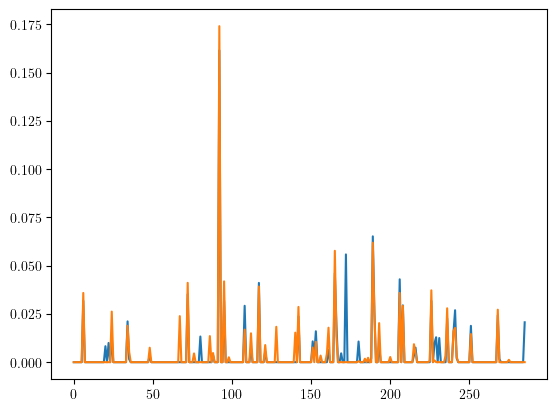

In [99]:
plt.plot(MVO2.x.x)
plt.plot(SVM_MVO_Fast.x.x)

NameError: name 'cols' is not defined

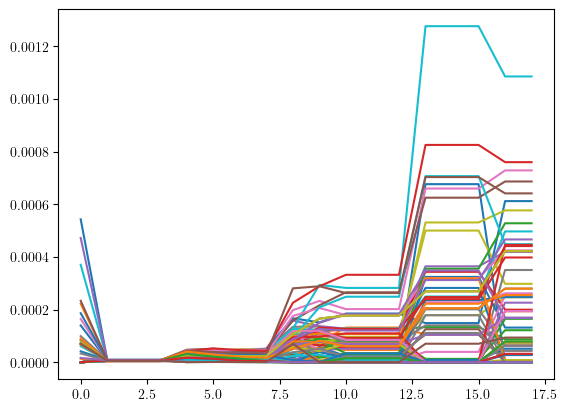

In [100]:
plt.plot(ws)
#plt.legend(cols)

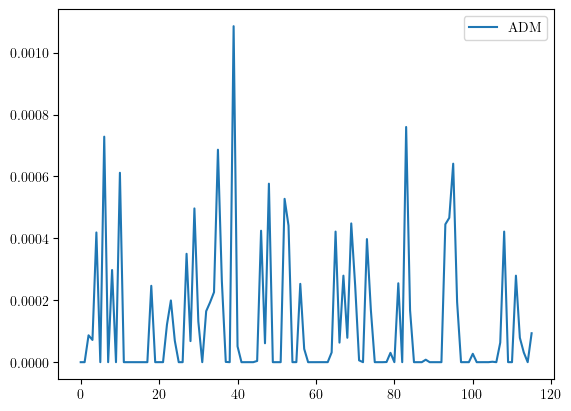

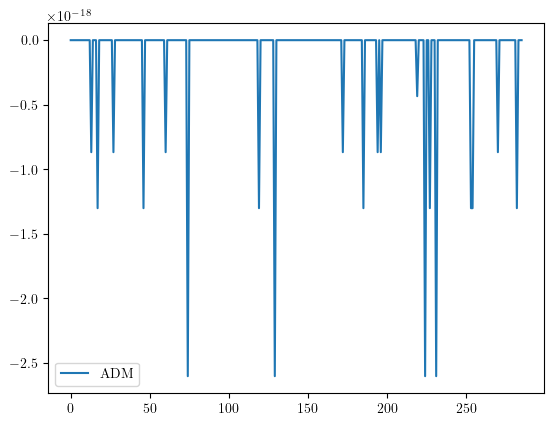

In [101]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

In [9]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

In [10]:
"".join(map(str, cols))

'INV3PRO6INV1Momentum'

In [11]:
for ratio, epsilon in product(ratios, epsilons):
    AssetLim = math.floor(N*ratio)

    SVM_MVO_Fast.MVO_.AssetLim = AssetLim
    SVM_MVO_Fast.MVO_.epsilon = epsilon
    SVM_MVO_Fast.SVM_.epsilon = epsilon
    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    isExist = os.path.exists("cache/Local Experiments/"+epsilons_desc[epsilon])
    if not isExist:
        os.makedirs("cache/Local Experiments/"+epsilons_desc[epsilon])
        print("The new directory is created!")
    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols,
                 turnover, lr=0.0, data_treatment=padm_data_treatment)
        col_string = "".join(map(str, cols))
        out_pth = "cache/Local Experiments/"+epsilons_desc[epsilon] + "/" + "padm" +card_desc + "_" +col_string + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
            pkl.dump(adm_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  28
Begin Relaxation
_________________________
Iteration  0
Percent Complete  0.0
[3.27902244e-12 3.68217840e-11 4.19064412e-06 2.47928702e-10]
Infeasible return constraint...Relaxing
_________________________
Iteration  12
Percent Complete  0.04938271604938271
[2.32219462e-12 1.28282896e-10 5.15140085e-15 2.41326452e-09]
_________________________
Iteration  24
Percent Complete  0.09876543209876543
[3.87356343e-12 7.22014772e-11 1.04831745e-14 9.02551088e-02]
_________________________
Iteration  36
Percent Complete  0.14814814814814814
[3.81865029e-13 3.59194325e-12 7.12065629e-16 6.48780252e-12]
_________________________
Iteration  48
Percent Complete  0.19753086419753085
[6.07933336e-15 3.78083269e-13 4.30087865e-17 8.80734707e-12]
_________________________
Iteration  60
Percent Complete  0.24691358024691357
[2.32154395e-12 3.18564861e-11 6.83421617e-15 8.32233808e-10]
_________________________
Iteration  72
Percent Complete  0.2962962962962963
[9.47877917e-15 


KeyboardInterrupt

